In [1]:
import numpy as np
from time import time

#lattice analysis
import igraph as ig
from collections import Counter

#plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#freq. analysis
from scipy.fft import fft
from scipy.optimize import curve_fit

### Forest Game Model

In [2]:
class Forest:
    def __init__(self, lattice_lenght, interaction ,p_death, p_birth, max_size, empty = False):
        self.L = lattice_lenght
        self.y = interaction
        self.p_death = p_death
        self.pb = p_birth
        self.S_max = max_size
        self.biomass_evolution = []
        
        #construction
        if empty:
            self.forest = np.zeros((self.L+4,self.L+4))
        else:
            self.forest = np.random.rand(self.L+4,self.L+4)*self.S_max
            
    def pd_quadratic(self,i,j):
        return (self.p_death/(self.S_max**2))*self.forest[i,j]
            
    def neighbors(self,i,j, second = False):
        if second:
            col = [i,i-2,i+2]
            raw = [j,j-2,j+2]
            return [(a,b) for a in col for b in raw][1:]
        else:
            col = [i,i-1,i+1]
            raw = [j,j-1,j+1]
            return [(a,b) for a in col for b in raw][1:]
        
   
    def step(self):
        for i in range(2, self.L+2):
            for j in range(2, self.L+2):
        
                if self.forest[i,j]==0:
                    self.birth(i,j)
                else:
                    self.growth(i,j)
        self.biomass_evolution.append(np.sum(self.forest))
            
    def ReLu(self,x):
        if x>=0:
            return x
        else:
            return 0
            
    def birth(self,i,j):
        if np.random.rand() < self.pb:
            self.forest[i,j] = 0.1
            

    def growth(self,i,j):
        if np.random.rand() < self.p_death:
            self.death(i,j)
            
        else:
            ds = self.increment(i,j)
            self.forest[i,j] += ds
            
            if self.forest[i,j] > self.S_max:
                self.death(i,j)
    
    def increment(self,i,j):
        #somma dei size dei primi vicini
        S = 0
        for index in self.neighbors(i,j):
            S += self.forest[index]
        S-=self.forest[i,j]
        
        return self.ReLu( 1- (self.y/8)*S )
        
        
    def death(self,i,j):
        
        S = self.forest[i,j]
        
        to_remove = 0
        to_remove_indeces = []
        
        #gap_formation

        for index in self.neighbors(i,j):
            to_remove += self.forest[index]
            if to_remove > S:
                break
            to_remove_indeces.append(index) 
        
        #second neighbors if nedeed
        #if to_remove < S:
        #    for index in self.neighbors(i,j, second = True):
        #        to_remove += self.forest[index]
        #        if to_remove > S:
        #            break
        #        to_remove_indeces.append(index)             
            
        for index in to_remove_indeces:
            self.forest[index] = 0
        self.forest[i,j] = 0
        
    def binary_forest(self,low_canopy):
        return self.forest[2:self.L+2,2:self.L+2] < low_canopy

### Model Simulation

several snapshots

In [102]:
lattice_lenght = 80
interaction = 0.1
p_death = 0.01
p_birth = 0.3
max_size = 30

7.1919004917144775 seconds


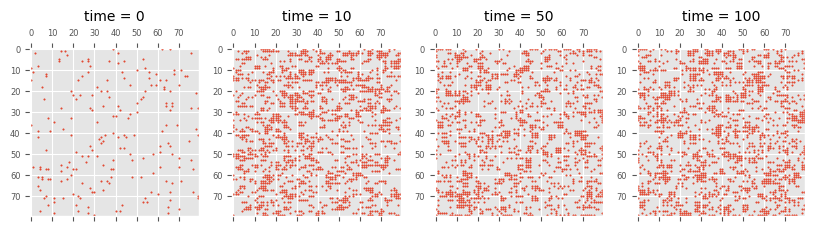

In [103]:
t_0 = time()

#time evolution plot
my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size)



t = {0:(0), 10:(1), 50:(2), 100:(3), 150:(4)}
fig, ax = plt.subplots(1,4, figsize = (10,6))

for epoch in range(101):
    if epoch in t.keys():
        ax[t[epoch]].spy(my_forest.binary_forest(low_canopy = 1), markersize=0.5)
        ax[t[epoch]].set_title(f'time = {epoch}', fontsize = 10)
        ax[t[epoch]].tick_params(axis='both', which='major', labelsize=6)
    my_forest.step()
    
#plt.imshow(my_forest.forest, cmap='jet')
#plt.colorbar()
t_1 = time()
print(t_1-t_0, 'seconds')

plt.show()

In [104]:
fig.savefig('lattice_evolution.png')

#### Biomass Evolution

In [88]:
lattice_lenght = 80
interaction = 0.1
p_birth = 0.3
p_death= 0.01
max_size = 30
max_epoch = 500

In [89]:
%%time

biomass = {}

for gamma in [0.1,0.01,1]:
    
    my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=gamma,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size)

    #evolution
    for epoch in range(max_epoch):
        my_forest.step()
        
    biomass[gamma] = my_forest.biomass_evolution

CPU times: total: 2min 47s
Wall time: 2min 48s


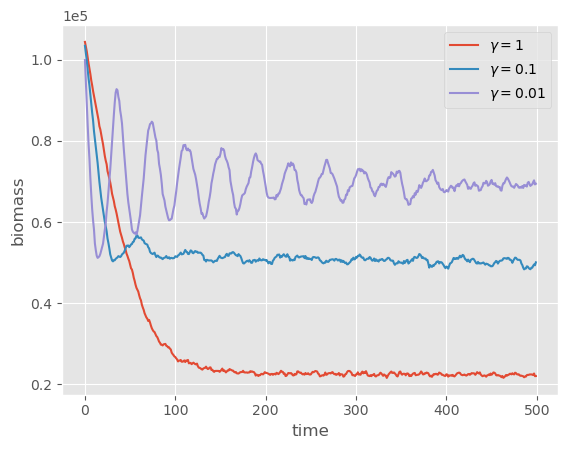

In [90]:
plt.plot(biomass[1], label = '$\gamma = 1$')
plt.plot(biomass[0.1], label = '$\gamma = 0.1$')
plt.plot(biomass[0.01], label = '$\gamma = 0.01$')
plt.xlabel('time')
#plt.yscale('log')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.ylabel('biomass')
plt.legend()
#plt.text(300,140000,'$\gamma = 0.1$')
plt.savefig('Biomass_Evolution_all.png')

#### Try different p_death

In [91]:
%%time
biomass = {}
#construction
for p in [0.01,0.025,0.05,0.1]:
    my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=0.1,
                   p_death=p,
                   p_birth=p_birth,
                   max_size=max_size)

    #evolution
    for epoch in range(max_epoch):
        my_forest.step()
    biomass[p] = my_forest.biomass_evolution

CPU times: total: 3min 25s
Wall time: 3min 25s


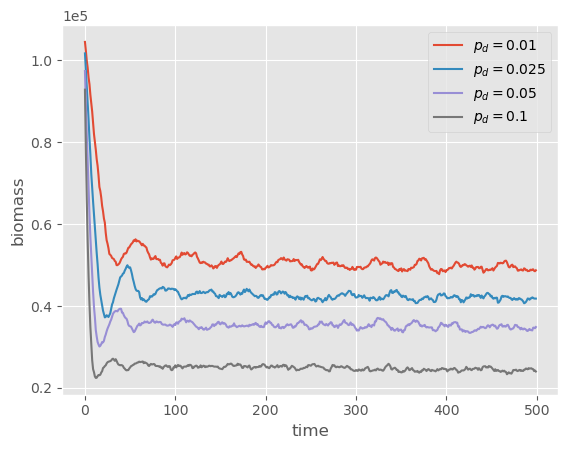

In [92]:
plt.plot(biomass[0.01], label = '$p_d = 0.01$')
plt.plot(biomass[0.025], label = '$p_d = 0.025$')
plt.plot(biomass[0.05], label = '$p_d = 0.05$')
plt.plot(biomass[0.1], label = '$p_d = 0.1$')
plt.xlabel('time')
#plt.yscale('log')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.ylabel('biomass')
plt.legend()
#plt.text(300,140000,'$\gamma = 0.1$')
plt.savefig('Biomass_Evolution_all_many_pd.png')

### Frequencies Analysis

transient after 150iterations

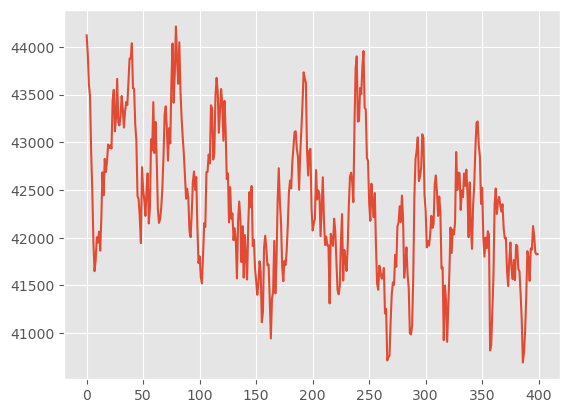

In [93]:
bio_evolution = biomass[0.025][100:]
plt.plot(bio_evolution)

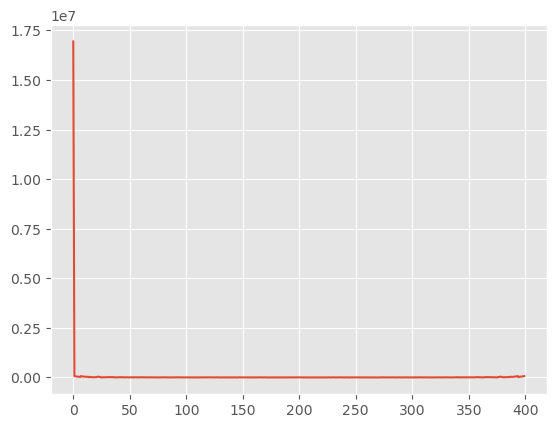

In [94]:
freq = fft(bio_evolution)
plt.plot(np.abs(freq))

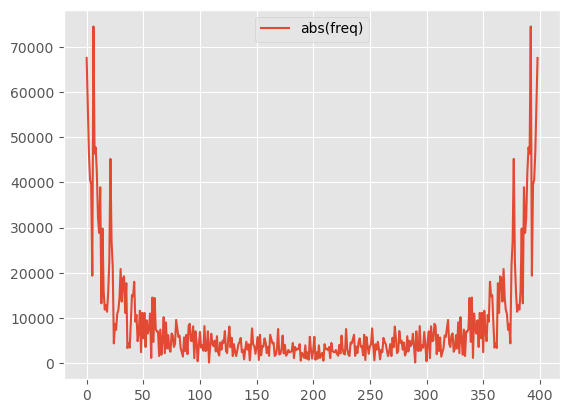

In [95]:
#ignore first component
#plt.plot(freq[1:], alpha = 0.8, label='freq')
plt.plot(np.abs(freq[1:]), label='abs(freq)')
plt.legend()

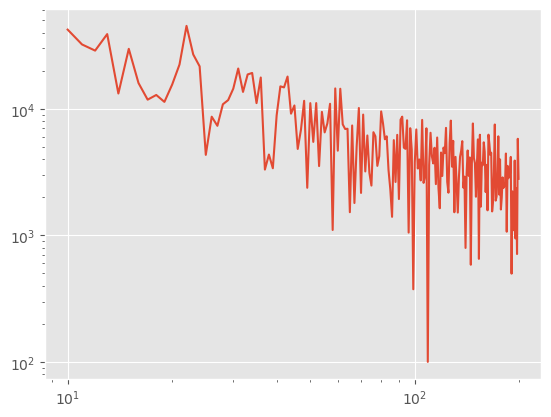

In [96]:
#symmetric spectrum -> plot firsrt half
plt.yscale('log')
plt.xscale('log')
plt.plot(range(10,200), np.abs(freq[10:200]))

In [97]:
#define fit function
def one_over_f(x,a,b,c):
    return a/((x*c)**b)

In [98]:
x_fit = np.arange(10,200)
y_fit = np.abs(freq[10:200])
opt, _ = curve_fit(one_over_f, x_fit, y_fit, p0 = [3e+04, 0.99, 8e-02] )

In [99]:
opt

array([5.46643117e+04, 8.89222444e-01, 1.62328978e-01])

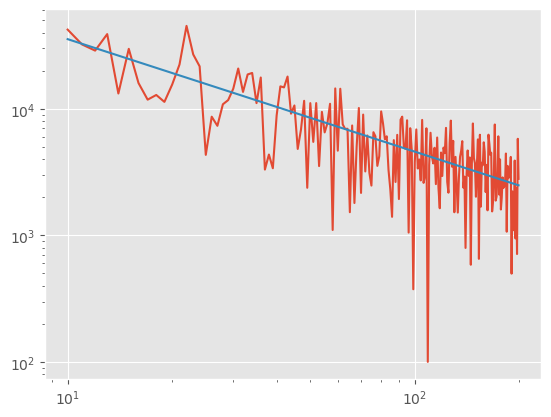

In [101]:
plt.yscale('log')
plt.xscale('log')
plt.plot(x_fit,np.abs(freq[10:200]))
plt.plot(x_fit,one_over_f(x_fit,*tuple(opt)))

plt.savefig('frequence_fit.png')

In [49]:
%%time
#media su 5 simulazioni
lattice_lenght = 80
interaction = 0.1
p_birth = 0.3
p_death= 0.025
max_size = 30
max_epoch = 500

five_forests = []
for i in range(5):
    #construction
    my_forest = my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size)

    #evolution
    for epoch in range(max_epoch):
        my_forest.step()
    five_forests.append(my_forest.biomass_evolution)
    

CPU times: total: 3min 36s
Wall time: 3min 56s


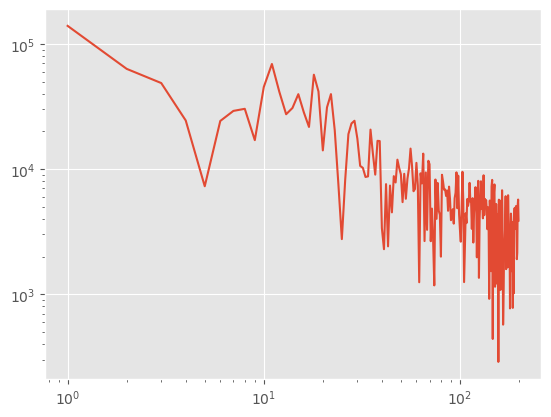

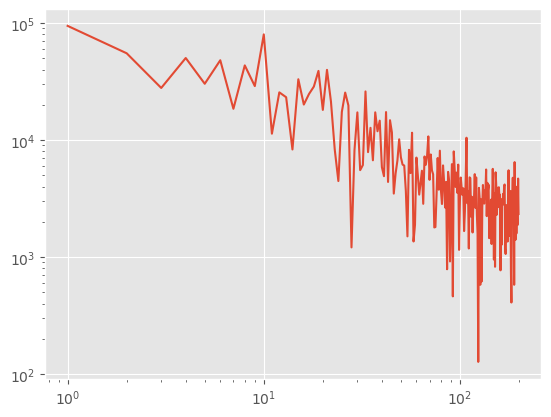

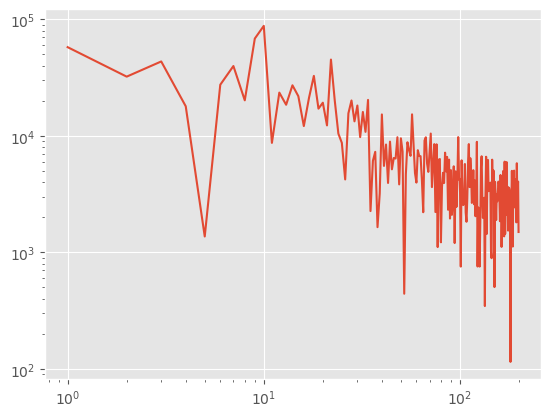

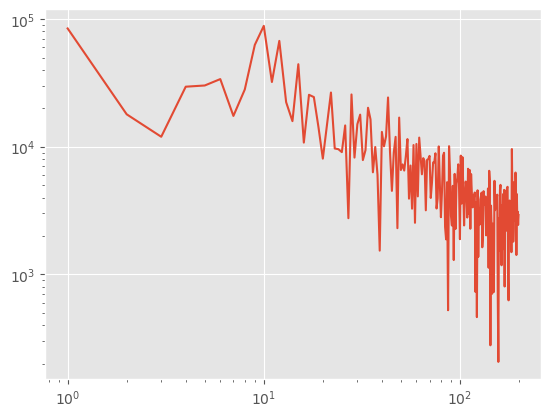

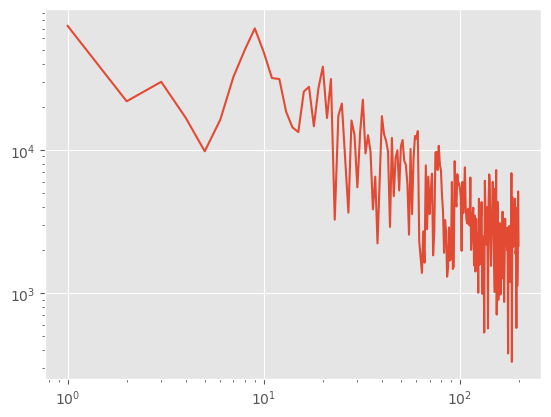

In [51]:
for biomass in five_forests:   
    freq = fft(biomass[100:]) 
    
    x_fit = np.arange(10,150) 
    y_fit = np.abs(freq[10:150]) 
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(range(1,200),np.abs(freq[1:200]))
    plt.show()

In [57]:
outs= []
for biomass in five_forests:   
    freq = fft(biomass[100:]) 
    x_fit = np.arange(10,200) 
    y_fit = np.abs(freq[10:200]) 
    opt, _ = curve_fit(one_over_f, x_fit, y_fit, p0 = [3e+04, 0.99, 8e-02])
    outs.append(opt)

C:\Users\Daniele\AppData\Local\Temp\ipykernel_5204\373312228.py:3: RuntimeWarning: invalid value encountered in power
  return a/((x*c)**b)


In [58]:
outs

[array([3.86598104e+04, 1.05554350e+00, 7.44072198e-02]),
 array([6.79770780e+04, 1.05358622e+00, 1.58317812e-01]),
 array([5.25045958e+04, 1.03324258e+00, 1.29190975e-01]),
 array([4.18943361e+04, 1.21628225e+00, 8.21218784e-02]),
 array([4.36775535e+04, 9.57147022e-01, 1.21661896e-01])]

In [60]:
betas =  [b[1] for b in outs]

In [63]:
beta_mean = np.mean(betas)
semi_disp = max(betas) - min(betas)

print(f'averaged exponent: {round(beta_mean,2)}')
print(f'semidispersion: {round(semi_disp,2)}')

averaged exponent: 1.06
semidispersion: 0.26


### Study on low-canopy gaps distribution

### Analyzer Class

study the forest, returnig gap size ditribution, fitting parameters, plot

In [6]:
class forest_analizer():
    
    def __init__(self,forest,low_canopy):
        self.forest  = forest
        self.low_canopy = low_canopy
        self.graph = self.to_graph()
        self.holes = self.hole_distribution()
        self.counter, self.hole_dim, self.hole_population = self.ordered_counter()
        self.exp, self.cost = self.fit()
        
        
    
    def to_graph(self):
        h = self.forest.L
        A = self.forest.binary_forest(self.low_canopy)
        edges = []
        node_counter = 0
        for i in range(h):
            for j in range(h):
                if j != h-1:
                    if A[i,j] == A[i,j+1] == 1: 
                        edges.append([node_counter , node_counter + 1])
                if i != h-1:
                    if A[i,j] == A[i+1,j] == 1:
                        edges.append([node_counter , node_counter + h])
                if j != h-1 and i != h-1:
                    if A[i,j] == A[i+1,j+1] == 1:
                        edges.append([node_counter , node_counter + h+1])
                if j != 0 and i != h-1:
                    if A[i,j] == A[i+1,j-1] == 1:
                        edges.append([node_counter , node_counter + h-1])


                node_counter += 1
        return ig.Graph(n = node_counter , edges = edges)
    
    def hole_distribution(self):
        components = self.graph.components()
        sizes = np.array(components.sizes())
        sizes = sizes[sizes>1] # not counting cluster made of one elementent, disconnected component in graph
        return sizes

    def powerlaw(self,x, m, c):
        return x**m * c
    
    def ordered_counter(self):
        c = Counter(self.holes)
        c = dict(sorted(c.items(), reverse=True))
        x = np.array(list(c.keys()))
        y = np.array(list(c.values()))
        return (c,x,y)
    
    def fit(self):  
        out, _ = curve_fit(self.powerlaw,self.hole_dim,self.hole_population)
        return out

    def plot_fitting(self, filename = None, log_scale = False ):
        ax = plt.subplot()
        if log_scale:
            plt.xscale('log')
            plt.yscale('log')
        ax.scatter(self.hole_dim,self.hole_population) 
        fit = self.hole_dim**self.exp * self.cost
        ax.plot(self.hole_dim, fit , color='green')
        if filename:
            plt.savefig(filename+'.png')
        plt.show()

In [7]:
#one function to do all the work
def main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy):
    my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size)
    
    for epoch in range(max_epoch):
        my_forest.step()
    
    my_analizer = forest_analizer(my_forest,low_canopy)
    return my_analizer

In [79]:
lattice_lenght = 100
interaction = 0.1
p_death = 0.01
p_birth = 0.3
max_size = 30
max_epoch = 150
low_canopy = 1

In [74]:
exp = []
t1 = time()

for i in range(5):

    out = main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy=0.1)
    exp.append(out.exp)
    
    print(f'exponent of gaps distribution: {out.exp:.2f}')
    #sns.displot(out.holes, log_scale = (True,True), bins = 40)

t2 = time()
print('time of execution :',t2-t1,'seconds')
    


exponent of gaps distribution: -1.80
exponent of gaps distribution: -1.55
exponent of gaps distribution: -1.63
exponent of gaps distribution: -1.69
exponent of gaps distribution: -1.68
time of execution : 143.04127550125122 seconds


In [78]:
print('exp media su 5 prove - p_death =',p_death)
print(f'media: {np.mean(exp):.2f}')
print(f'std: {np.std(exp):.2f}')
print(f'semidispersione: {np.max(exp) - np.min(exp):.2f}')

exp media su 5 prove - p_death = 0.01
media: -1.67
std: 0.08
semidispersione: 0.25


In [80]:
#an other simulation with small pd

lattice_lenght = 100
interaction = 0.1
p_death = 0.025
p_birth = 0.3
max_size = 30
max_epoch = 150
low_canopy = 1

exp = []
t1 = time()

for i in range(5):

    out = main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy=0.1)
    exp.append(out.exp)
    
    print(f'exponent of gaps distribution: {out.exp:.2f}')
    #sns.displot(out.holes, log_scale = (True,True), bins = 40)

t2 = time()
print('time of execution :',t2-t1,'seconds')

print('exp media su 5 prove - p_death =',p_death)
print(f'media: {np.mean(exp):.2f}')
print(f'std: {np.std(exp):.2f}')
print(f'semidispersione: {np.max(exp) - np.min(exp):.2f}')


exponent of gaps distribution: -1.57
exponent of gaps distribution: -1.65
exponent of gaps distribution: -1.75
exponent of gaps distribution: -1.67
exponent of gaps distribution: -1.54
time of execution : 82.2154791355133 seconds
exp media su 5 prove - p_death = 0.025
media: -1.64
std: 0.08
semidispersione: 0.21


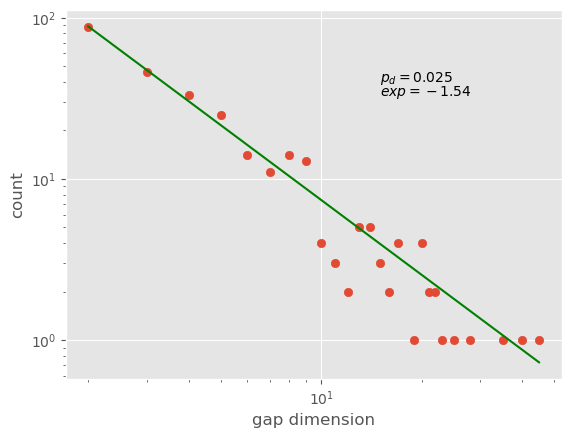

In [85]:
#plt.ylim(bottom = -0.5, top = 4.5)
plt.xlabel('gap dimension')
plt.ylabel('count')
plt.text(15,40,'$p_d = 0.025$' )
plt.text(15,33,'$exp = -1.54$')
out.plot_fitting(log_scale = True, filename = 'fit')

In [13]:
#now greater

lattice_lenght = 100
interaction = 0.1
p_death = 0.05
p_birth = 0.3
max_size = 30
max_epoch = 150
low_canopy = 1

exp = []
t1 = time()

for i in range(5):

    out = main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy=0.1)
    exp.append(out.exp)
    
    print(f'exponent of gaps distribution: {out.exp:.2f}')
    sns.displot(out.holes, log_scale = (True,True), bins = 40)

t2 = time()
print('time of execution :',t2-t1,'seconds')

print('exp media su 5 prove - p_death =',p_death)
print(f'media: {np.mean(exp):.2f}')
print(f'std: {np.std(exp):.2f}')
print(f'semidispersione: {np.max(exp) - np.min(exp):.2f}')

exponent of gaps distribution: -1.55
exponent of gaps distribution: -1.39
exponent of gaps distribution: -1.45
exponent of gaps distribution: -1.40
exponent of gaps distribution: -1.39
time of execution : 133.8859989643097 seconds
exp media su 5 prove - p_death = 0.05
media: -1.43
std: 0.06
semidispersione: 0.16


exponent of gaps distribution: -1.84
exponent of gaps distribution: -2.03
exponent of gaps distribution: -1.52
exponent of gaps distribution: -1.46
exponent of gaps distribution: -1.54
time of execution : 111.85900068283081 seconds
exp media su 5 prove - p_death = 0.1
media: -1.68
std: 0.22
semidispersione: 0.57


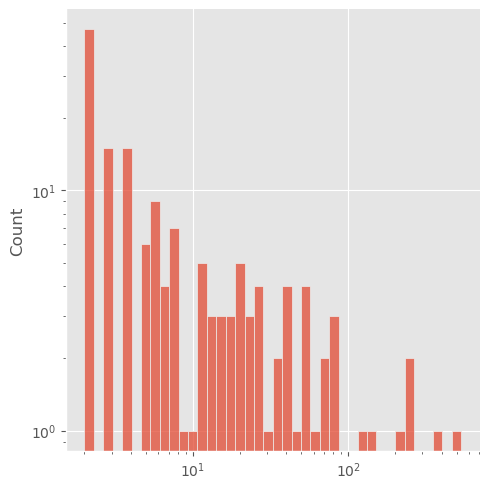

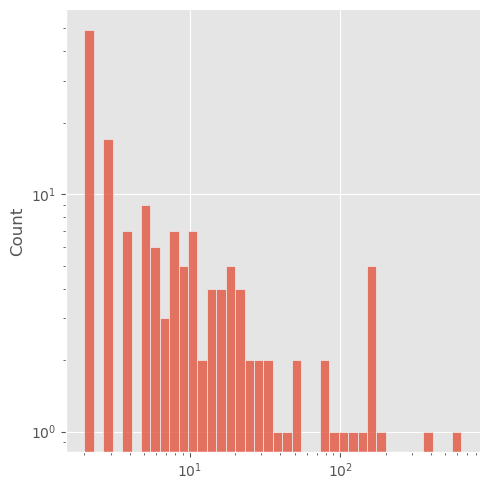

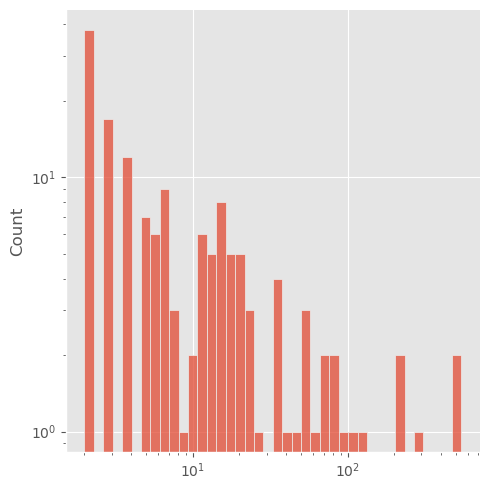

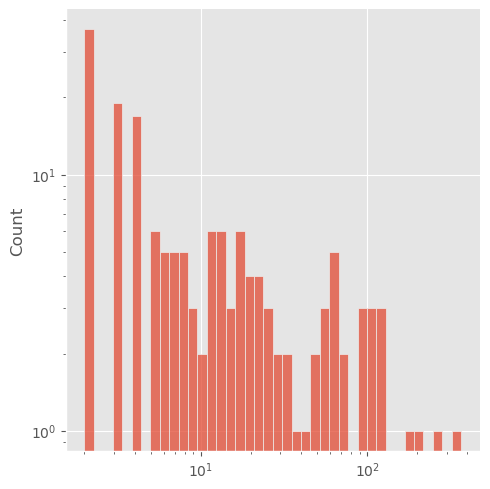

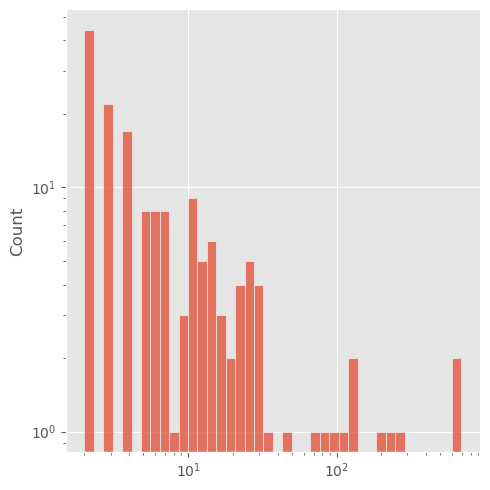

In [11]:
#now greater

lattice_lenght = 100
interaction = 0.1
p_death = 0.1
p_birth = 0.3
max_size = 30
max_epoch = 150
low_canopy = 1

exp = []
t1 = time()

for i in range(5):

    out = main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy=0.1)
    exp.append(out.exp)
    
    print(f'exponent of gaps distribution: {out.exp:.2f}')
    sns.displot(out.holes, log_scale = (True,True), bins = 40)

t2 = time()
print('time of execution :',t2-t1,'seconds')

print('exp media su 5 prove - p_death =',p_death)
print(f'media: {np.mean(exp):.2f}')
print(f'std: {np.std(exp):.2f}')
print(f'semidispersione: {np.max(exp) - np.min(exp):.2f}')

### Last simulation whit age-dependent probability of death


In [19]:
class Forest:
    def __init__(self, lattice_lenght, interaction ,p_death, p_birth, max_size, empty = False):
        self.L = lattice_lenght
        self.y = interaction
        self.p_death = p_death
        self.pb = p_birth
        self.S_max = max_size
        self.biomass_evolution = []
        
        #construction
        if empty:
            self.forest = np.zeros((self.L+4,self.L+4))
        else:
            self.forest = np.random.rand(self.L+4,self.L+4)*self.S_max
            
    def pd_quadratic(self,i,j):
        return (self.p_death/(self.S_max**2))*self.forest[i,j]
            
    def neighbors(self,i,j, second = False):
        if second:
            col = [i,i-2,i+2]
            raw = [j,j-2,j+2]
            return [(a,b) for a in col for b in raw][1:]
        else:
            col = [i,i-1,i+1]
            raw = [j,j-1,j+1]
            return [(a,b) for a in col for b in raw][1:]
        
   
    def step(self):
        for i in range(2, self.L+2):
            for j in range(2, self.L+2):
        
                if self.forest[i,j]==0:
                    self.birth(i,j)
                else:
                    self.growth(i,j)
        self.biomass_evolution.append(np.sum(self.forest))
            
    def ReLu(self,x):
        if x>=0:
            return x
        else:
            return 0
            
    def birth(self,i,j):
        if np.random.rand() < self.pb:
            self.forest[i,j] = 0.1
            

    def growth(self,i,j):
        if np.random.rand() < self.pd_quadratic(i,j):
            self.death(i,j)
            
        else:
            ds = self.increment(i,j)
            self.forest[i,j] += ds
            
            if self.forest[i,j] > self.S_max:
                self.death(i,j)
    
    def increment(self,i,j):
        #somma dei size dei primi vicini
        S = 0
        for index in self.neighbors(i,j):
            S += self.forest[index]
        S-=self.forest[i,j]
        
        return self.ReLu( 1- (self.y/8)*S )
        
        
    def death(self,i,j):
        
        S = self.forest[i,j]
        
        to_remove = 0
        to_remove_indeces = []
        
        #gap_formation

        for index in self.neighbors(i,j):
            to_remove += self.forest[index]
            if to_remove > S:
                break
            to_remove_indeces.append(index) 
        
        #second neighbors if nedeed
        #if to_remove < S:
        #    for index in self.neighbors(i,j, second = True):
        #        to_remove += self.forest[index]
        #        if to_remove > S:
        #            break
        #        to_remove_indeces.append(index)             
            
        for index in to_remove_indeces:
            self.forest[index] = 0
        self.forest[i,j] = 0
        
    def binary_forest(self,low_canopy):
        return self.forest[2:self.L+2,2:self.L+2] < low_canopy

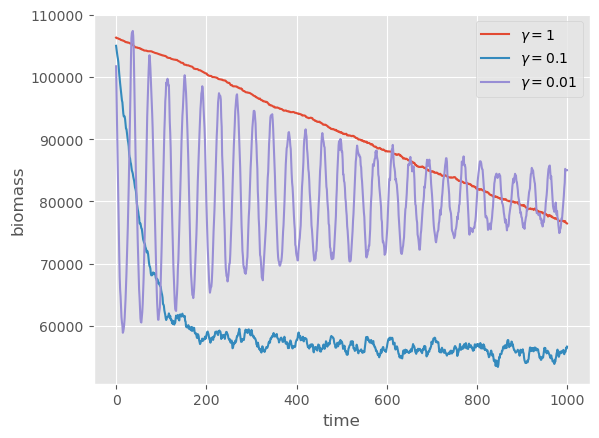

CPU times: total: 4min 32s
Wall time: 4min 33s


In [27]:
%%time
lattice_lenght = 80
p_birth = 0.3
p_death = 0.01
max_size = 30
max_epoch = 1000

biomass = {}

for gamma in [0.1,0.01,1]:
    
    my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=gamma,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size)

    #evolution
    for epoch in range(max_epoch):
        my_forest.step()
        
    biomass[gamma] = my_forest.biomass_evolution
    
plt.plot(biomass[1], label = '$\gamma = 1$')
plt.plot(biomass[0.1], label = '$\gamma = 0.1$')
plt.plot(biomass[0.01], label = '$\gamma = 0.01$')
plt.xlabel('time')
#plt.yscale('log')
#plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.ylabel('biomass')
plt.legend()
plt.show()
#plt.text(300,140000,'$\gamma = 0.1$')
#plt.savefig('Biomass_Evolution_all.png')

In [32]:
%%time
lattice_lenght = 80
p_birth = 0.3
p_death = 0.01
max_size = 30
max_epoch = 1000

biomass = {}

for gamma in [0.01,0.05,0.1]:
    
    my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=gamma,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size)

    #evolution
    for epoch in range(max_epoch):
        my_forest.step()
        
    biomass[gamma] = my_forest.biomass_evolution
    


CPU times: total: 4min 58s
Wall time: 5min


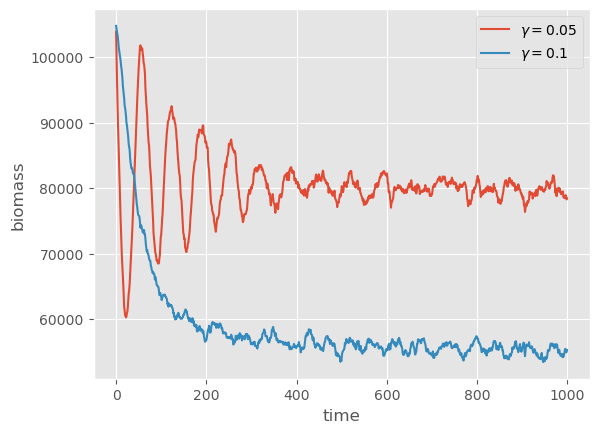

In [35]:
#plt.plot(biomass[0.01], label = '$\gamma = 0.01$')
plt.plot(biomass[0.05], label = '$\gamma = 0.05$')
plt.plot(biomass[0.1], label = '$\gamma = 0.1$')
plt.xlabel('time')
#plt.yscale('log')
#plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.ylabel('biomass')
plt.legend()
plt.show()
#plt.text(300,140000,'$\gamma = 0.1$')
#plt.savefig('Biomass_Evolution_all.png')

9.067997455596924 seconds


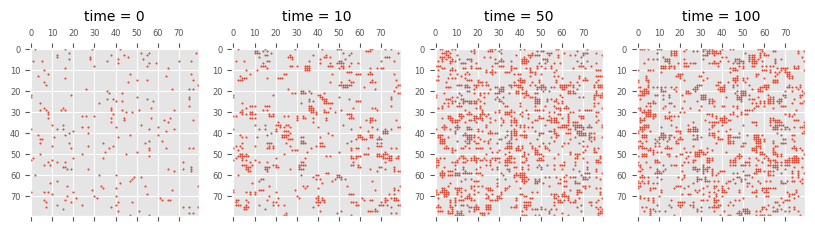

In [34]:
t_0 = time()

#time evolution plot
my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size)



t = {0:(0), 10:(1), 50:(2), 100:(3), 150:(4)}
fig, ax = plt.subplots(1,4, figsize = (10,6))

for epoch in range(101):
    if epoch in t.keys():
        ax[t[epoch]].spy(my_forest.binary_forest(low_canopy = 1), markersize=0.5)
        ax[t[epoch]].set_title(f'time = {epoch}', fontsize = 10)
        ax[t[epoch]].tick_params(axis='both', which='major', labelsize=6)
    my_forest.step()
    
#plt.imshow(my_forest.forest, cmap='jet')
#plt.colorbar()
t_1 = time()
print(t_1-t_0, 'seconds')

plt.show()